## Деревья решений

# Урок 4. Деревья решений.
## ДЗ (03.05.2021)

* [Практическое задание. ДЗ.](#ex)
    * [Задание](#ex)

* [Теория](#theor)
    * [Дополнительные материалы](#theor)

## <center><a class="anchor" id="ex">Практическое задание </a><center>

### <a class="anchor" id="ex1">Задание </a>

1) реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации

2) реализовать ограничение глубины дерева при построении. Построить на этом же датасете дерево, у которого максимальная глубна листа равна 2.

В этом уроке пойдет речь еще об одном популярном методе машинного обучения - деревьях решений. Это семейство алгоритмов значительно отличается от линейных моделей, но применяется также в задачах классификации и регрессии.

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection
from graphviz import Digraph
%matplotlib inline

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features=2, n_informative=2,
                                                                          n_classes=2, n_redundant=0,
                                                                          n_clusters_per_class=1, random_state=5)

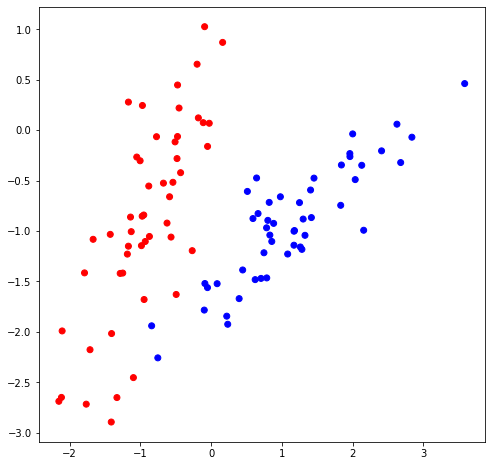

In [ ]:
# Визуализируем данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

In [ ]:
# Реализуем клас для постороения дерева с учетом ограничения на глубину и с выбором критерия информатиности

class Tree:

    def __init__(self, classification_data, classification_labels, crit='gini', node_limit = 5):

        self.node_count = 0
        self.node_limit = node_limit

        self.train_data, self.test_data, self.train_labels, self.test_labels = \
            model_selection.train_test_split(classification_data,
                                             classification_labels,
                                             test_size=0.3,
                                             random_state=1)

        self.crit = crit
        # Построим дерево по обучающей выборке
        self.my_tree = self.build_tree(self.train_data, self.train_labels)

        # Получим ответы для обучающей выборки
        self.train_answers = self.predict(self.train_data, self.my_tree)

        # И получим ответы для тестовой выборки
        self.answers = self.predict(self.test_data, self.my_tree)

        self.train_accuracy = self.accuracy_metric(self.train_labels, self.train_answers)
        self.test_accuracy = self.accuracy_metric(self.test_labels, self.answers)




    # Напечатаем ход нашего дерева
    def print_tree(self, node, spacing=""):
        # Если лист, то выводим его прогноз
        if isinstance(node, self.Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> True:')
        self.print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> False:')
        self.print_tree(node.false_branch, spacing + "  ")


    class Node:

        def __init__(self, index, t, true_branch, false_branch):
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t  # значение порога
            self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

    # И класс терминального узла (листа)

    class Leaf:

        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            self.prediction = self.predict()

        def predict(self):
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1
            #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
            prediction = max(classes, key=classes.get)
            return prediction

    def q_crit(self, labels):

        if self.crit == 'gini':
            #  подсчет количества объектов разных классов
            classes = {}
            for label in labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1

            #  расчет критерия
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2

            return impurity

        elif self.crit == 'entr':

            _, cnt = np.unique(labels, return_counts=True)
            p = cnt / np.sum(cnt)

            H = -np.sum(p * np.log2(p))

            return H

        else:
            print('Скорее всего дерево построено не правильно')
            return 0

    def quality(self, left_labels, right_labels, current_crit):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_crit - p * self.q_crit(left_labels) - (1 - p) * self.q_crit(right_labels)

    # Разбиение датасета в узле

    def split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_crit = self.q_crit(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_crit)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels):
        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качестве или превышен лимит для дерева

        # if quality == 0 or self.node_count == self.node_limit:
        if quality == 0 or (self.node_count > (2**self.node_limit+1)): # вот так наверное надо делать останов?
            return self.Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        self.node_count += 1
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data, tree):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, tree)
            classes.append(prediction)
        return classes


    # Введем функцию подсчета точности как доли правильных ответов
    def accuracy_metric(self, actual, predicted):
        return np.sum(actual == predicted) / len(actual)

    def balanced_accuracy_metric(self, actual, predicted):
        true_predicted = (actual == predicted).astype(int)
        sensitivity = np.sum(actual * true_predicted) / np.sum(actual == 1)
        specificity = np.sum((1 - actual) * true_predicted) / np.sum(actual == 0)
        return 0.5 * (sensitivity + specificity)
    #
    def accuracy(self):

    # Точность на обучающей выборке
        print('Точность на обучающей выборке\n', self.accuracy_metric(self.train_labels, self.train_answers),
              self.balanced_accuracy_metric(self.train_labels, self.train_answers))

        # Точность на тестовой выборке
        print('Точность на тестовой выборке\n', self.accuracy_metric(self.test_labels, self.answers),
              self.balanced_accuracy_metric(self.test_labels, self.answers))


    def visualisation(self):
        # Визуализируем дерево на графике

        def get_meshgrid(data, step=.05, border=1.2):
            x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
            y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
            return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


        plt.figure(figsize=(10, 4))

        # график обучающей выборки
        plt.subplot(1, 2, 1)
        xx, yy = get_meshgrid(self.train_data)
        mesh_predictions = np.array(self.predict(np.c_[xx.ravel(), yy.ravel()], self.my_tree)).reshape(xx.shape)
        plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto', )
        plt.scatter(self.train_data[:, 0], self.train_data[:, 1], c=self.train_labels, cmap=colors)
        plt.title(f'Train accuracy={self.train_accuracy:.2f}')

        # график тестовой выборки
        plt.subplot(1, 2, 2)
        plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto', )
        plt.scatter(self.test_data[:, 0], self.test_data[:, 1], c=self.test_labels, cmap=colors)
        plt.title(f'Test accuracy={self.test_accuracy:.2f}')
        # plt.show()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1
Точность на обучающей выборке
 0.9857142857142858 0.9857142857142858
Точность на тестовой выборке
 1.0 1.0


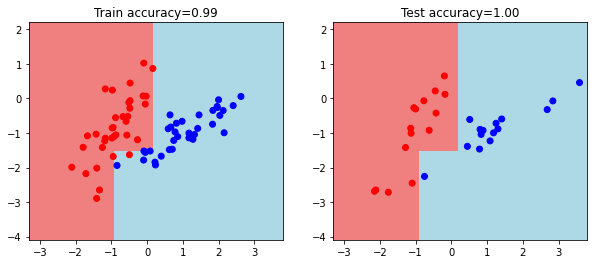

In [ ]:
tree_lesson = Tree(classification_data, classification_labels)
tree_lesson.print_tree(tree_lesson.my_tree)
tree_lesson.accuracy()
tree_lesson.visualisation()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1
Точность на обучающей выборке
 0.9857142857142858 0.9857142857142858
Точность на тестовой выборке
 1.0 1.0


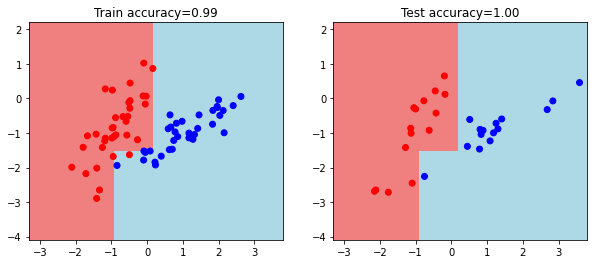

In [ ]:
# ... с ограничением по глубине

tree_lesson_limit = Tree(classification_data, classification_labels, node_limit=2)
tree_lesson_limit.print_tree(tree_lesson_limit.my_tree)
tree_lesson_limit.accuracy()
tree_lesson_limit.visualisation()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1
Точность на обучающей выборке
 0.9857142857142858 0.9857142857142858
Точность на тестовой выборке
 1.0 1.0


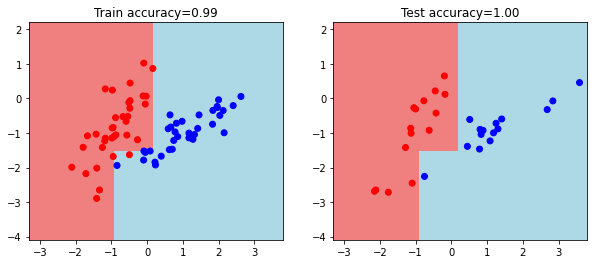

In [ ]:
# ... Шеннон вместо Джини
tree_lesson_entr_shen = Tree(classification_data, classification_labels, crit='entr')
tree_lesson_entr_shen.print_tree(tree_lesson_entr_shen.my_tree)
tree_lesson_entr_shen.accuracy()
tree_lesson_entr_shen.visualisation()

### Разницы в расчетах точности не выявлено.

Проверим еще:

In [ ]:
# сгенерируем данные
classification_data1, classification_labels1 = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                                                          n_classes=2, n_redundant=0,
                                                                          n_clusters_per_class=1, random_state=1)

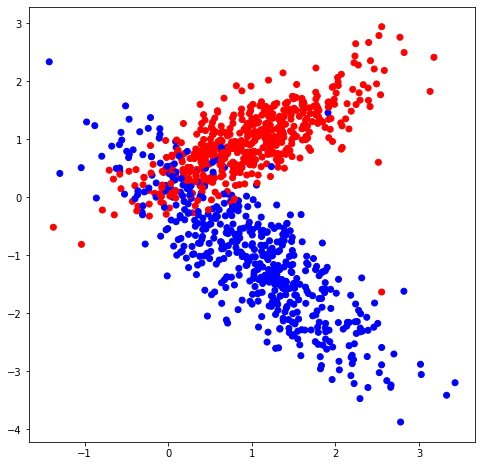

In [ ]:
# Визуализируем данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data1)), list(map(lambda x: x[1], classification_data1)),
            c=classification_labels1, cmap=colors)

Точность на обучающей выборке
 0.9542857142857143 0.953949785670545
Точность на тестовой выборке
 0.9266666666666666 0.9281423804226918


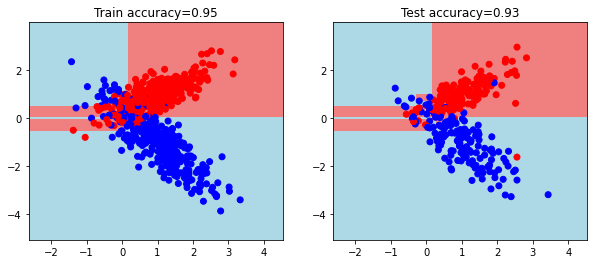

In [ ]:
tree1 = Tree(classification_data1, classification_labels1)
tree1.accuracy()
tree1.visualisation()

Точность на обучающей выборке
 0.9542857142857143 0.953949785670545
Точность на тестовой выборке
 0.9266666666666666 0.9281423804226918


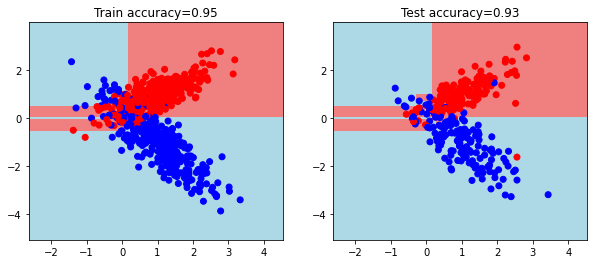

In [ ]:
tree2 = Tree(classification_data1, classification_labels1, node_limit=30)
tree2.accuracy()
tree2.visualisation()

Точность на обучающей выборке
 0.96 0.9596652378036334
Точность на тестовой выборке
 0.9166666666666666 0.917575083426029


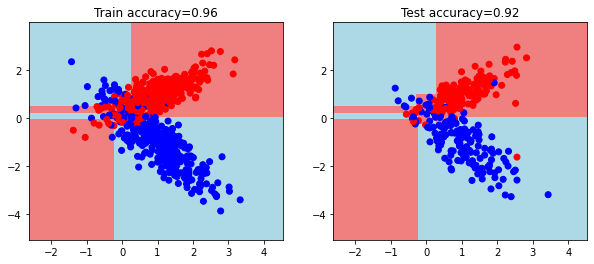

In [ ]:
tree3 = Tree(classification_data1, classification_labels1, crit='entr', node_limit=30)
tree3.accuracy()
tree3.visualisation()

Использование критерия __Джини__ показывает лучшие результаты на тестовой выборке не смотря на то что на обучающей выборке результаты ниже, но учитывая разницу в 1% это не критично. Оба критерия одинаково приемлемы.

## Дополнительные материалы

## Пример:

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

### Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

### Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

### Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

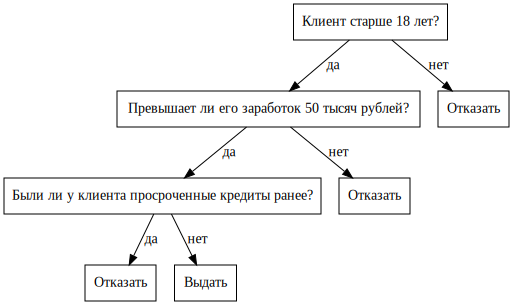

In [ ]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

dot

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)